# TSIA202b - Spectral Estimation

In [9]:
import numpy as np
from scipy import signal
import librosa
import matplotlib.pyplot as plt
import statsmodels.regression.linear_model as srlm
import pyaudio
import scipy.io.wavfile
from IPython.display import Audio
import os 
import wave
import sys 
import struct

# 1 Autoregressive process


 __1.1 Synthesis__

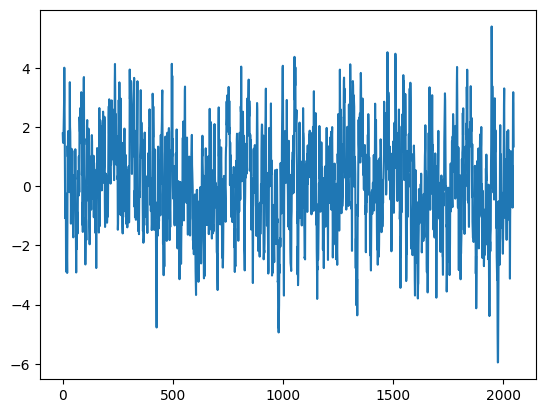

In [10]:
N = 2048 #Number of samples 
sigma2 = 1 #variance 

def AR(N, coeffs, sigma2):
    """Returns a numpy array of length N with samples
    from an AR process with coefficients coeffs = [a_1, a_2, ...]
    and innovatison variance sigma2"""
    proc = np.zeros(N)
    p = coeffs.size
    sigma = np.sqrt(sigma2)
    for t in range(N):
        proc[t] = np.random.normal(0, sigma) + np.sum([coeffs[n-1] * proc[t-n] for n in range(1, p+1)])
    return proc


coeffs_0 = np.array([0.75])  
AR_0 = AR(N,coeffs_0,sigma2)
plt.plot(AR_0)
plt.show()

A process is AR(p) if and only if it is Wide Sens Stationary and it verifies : 
$$ \forall t , X_t = Z_t + \sum_{n=1}^p a_n X_{t-n}$$ 

With $Z ~ WN(0, \sigma^2)$

__1.2 Non-parametric estimation : periodogram__

In [11]:
def periodogram(X,method,L = None,M = None):
    """
    Input : 
    X : Process 
    L,M : Welch and Barlett parameters  
    w : window 
    
    Output : Estimated periodogram using a specific method 
    
    """
    N = X.size
    if method =='std':
        pdgm = (1/N)*abs(np.fft.fft(X))**2 

        return (np.linspace(-.5, .5, num=N), np.roll(pdgm, pdgm.size//2))
    # Splits the data and averages several periodogramsto reduce the variance
    # N signal samples are segmented into L sub-samples of size M = N/L
    elif method == 'Bartlett':

        L = N // M
        pdgm = 0
        for i in range(1,L+1):
            pdgm += (L/N)*abs(np.fft.fft(X[(i-1)*M:i*M], n = N))**2
        pdgm /= L
        return (np.linspace(-.5, .5, num=N), np.roll(pdgm, pdgm.size//2))
    # Same as in Barlet, but the windows overlap and the sub-processes are windowed 
    elif method == "Welch" : 
        pdgm = 0 
        v = np.hamming(M)
        P = np.sum(np.abs(v[:M])**2) / M
        K = M//2
        S = 2 * N // M - 1
        for i in range(0,S):
            X_tilde = X[i*K:i*K+M] 
            pdgm += (1/(M*P))*abs(np.fft.fft(np.array([v[i]*X_tilde[i] for i in range(len(X_tilde))]), n= N))**2
        pdgm /= S 
        return (np.linspace(-.5, .5, num=N), np.roll(pdgm, pdgm.size//2))
    else :
        print("Wrong method ")
        return 0
        

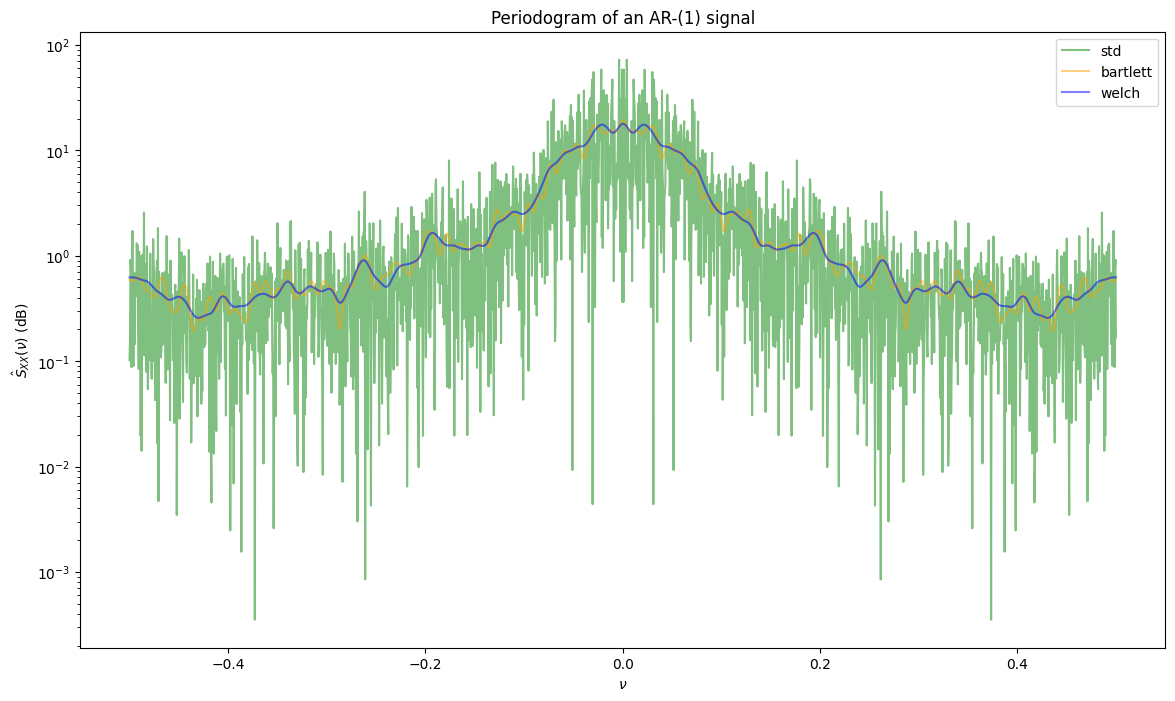

In [12]:
fig = plt.figure(figsize=(14, 8))
# std
nus, S_hat_std = periodogram(AR_0, method="std")
plt.plot(nus, S_hat_std, c='green', alpha=.5, label="std")
# barlett
nus_bartlett, S_hat_bartlett = periodogram(AR_0, method="Bartlett", M= 100)
plt.plot(nus_bartlett, S_hat_bartlett, c='orange', alpha=.5, label="bartlett")
# welsh 
a, b = periodogram(AR_0,method='Welch', M= 100)
plt.plot(a, b, c='blue', alpha=.5, label="welch")

# theoretical psd
#np.linspace(-.5, .5, num=N)
#Sxx = [sigma2 / np.abs(1 - coeffs_0[0]*np.exp(-2*1j*np.pi*nu))**2 for nu in nus]
#plt.plot(nus, Sxx, c='r', linestyle='dashed', label="theoretical")

plt.legend()
plt.title("Periodogram of an AR-(1) signal")
plt.xlabel(r"$\nu$")
plt.ylabel(r"$\hat{S}_{XX}(\nu)$ (dB)")
plt.yscale("log")
plt.legend()
plt.show()

We can see that the results are much smoother for the __Barlett__ and the __Welsch__ method. 

__1.3 Parametric estimation : linear prediction__

In [13]:
est_coeffs_librosa = librosa.lpc(AR_0, order=1)
est_coeffs_librosa = -est_coeffs_librosa[1:] 
print(est_coeffs_librosa) #Estimation is good ! 

[0.76404925]


In [14]:
est_coeffs_burg, est_sigma2_burg = srlm.burg(AR_0, order=1)
print(est_coeffs_burg,est_sigma2_burg)

[0.76307935] 1.1155467617705543


In [15]:
est_coeffs_yw, est_sigma2_yw = srlm.yule_walker(AR_0, order=1)
print(est_coeffs_yw, est_sigma2_yw)

[0.76314681] 1.0560176415403735


The results are very good !

In [16]:
def psd_ar(coeffs, sigma2, M):
    """
    Input : 
    Coeffs : coeffs of the AR process
    sigma2 : Variance 
    M : step for frequencies 
    Output : 
    PSD of the AR process
    AR_coeffs = [a_1, a_2, ...] and a_0 = 1"""
    coeffs = np.concatenate(([1], -coeffs)) 
    ft = np.fft.fft(coeffs, n=M)
    return np.arange(-.5, .5, step=1/M), sigma2 / np.roll(np.abs(ft)**2, M//2)

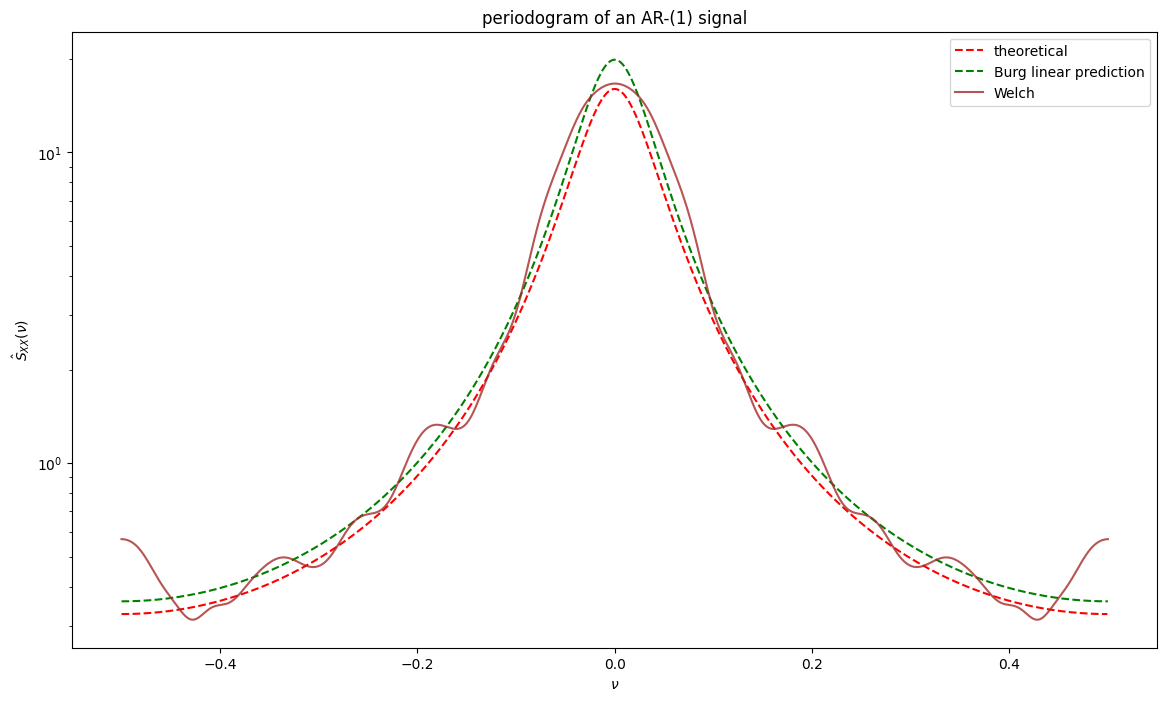

In [17]:
fig = plt.figure(figsize=(14, 8))

# theoretical psd
X, Y = psd_ar(coeffs_0, sigma2, N)
plt.plot(X, Y, c='r', linestyle='dashed', label="theoretical")

# estimated psd
Sxx_burg = [est_sigma2_burg / np.abs(1 - est_coeffs_burg[0]*np.exp(-2*1j*np.pi*nu))**2 for nu in nus]
plt.plot(nus, Sxx_burg, c='green', linestyle='dashed', label="Burg linear prediction")

# welch
nus, S_hat_welch = periodogram(AR_0, method="Welch",M = 35)
plt.plot(nus, S_hat_welch, c='brown', alpha=.8, label="Welch")

plt.title("periodogram of an AR-(1) signal")
plt.xlabel(r"$\nu$")
plt.ylabel(r"$\hat{S}_{XX}(\nu)$")
plt.yscale("log")
plt.legend()
plt.show()

The Theoretical and linear prediction with estimated coefficients are __matching perfectly__. 
Welch is also pretty good but less precise. 

__1.4 Application to speech signals__

In [18]:
def load_sound(file):
    return wave.open(file, 'rb')


def play_sound(file, chunk = 1024):
    """
    Script from PyAudio doc
    """
    wf = load_sound(file)
    p = pyaudio.PyAudio()
    stream = p.open(format=p.get_format_from_width(wf.getsampwidth()),
                    channels=wf.getnchannels(),
                    rate=wf.getframerate(),
                    output=True)
    data = wf.readframes(chunk)

    while data:
        stream.write(data)
        data = wf.readframes(chunk )

    stream.stop_stream()
    stream.close()
    p.terminate()
    
    
def plot_sound(data, times, name='default_name', save=False):
    plt.figure(figsize=(30, 4))
    plt.fill_between(times, data)
    plt.xlim(times[0], times[-1])
    plt.xlabel('time (s)')
    plt.ylabel('amplitude')
    if save:
        plt.savefig(name+'.png', dpi=100)
    plt.show()

In [19]:
data_path = os.getcwd()
filename = 'aeiou.wav'
sound = os.path.join(data_path, filename)

In [20]:
play_sound(sound)

In [21]:
wavefile = load_sound(sound)
Fs = int(wavefile.getframerate())
num_samples = int(wavefile.getnframes())
data = wavefile.readframes(num_samples)
data = struct.unpack('{n}h'.format(n=num_samples), data)
x = np.array(data)
print(Fs)

11025


In [22]:
timestep = 1/float(Fs)
times = np.arange(len(x))*timestep

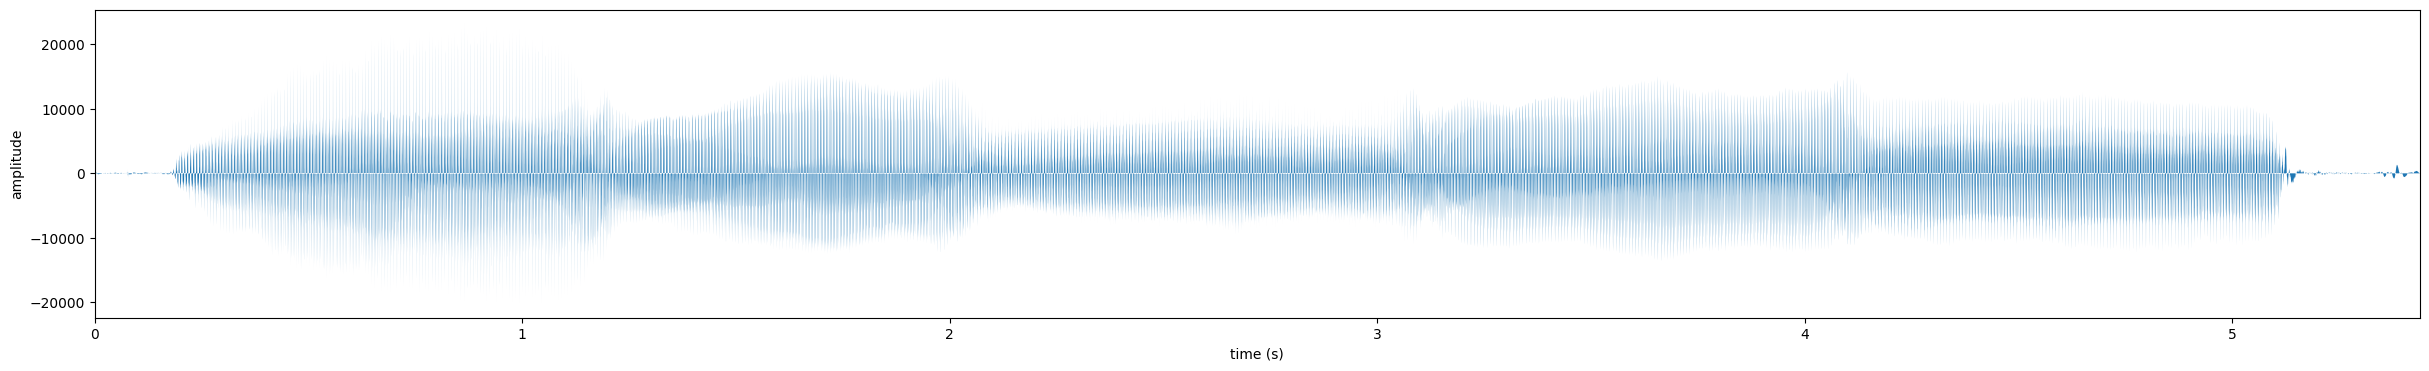

In [23]:
plot_sound(x, times)

In [24]:
letter_a = x[0:12500]
Audio(letter_a, rate=Fs)

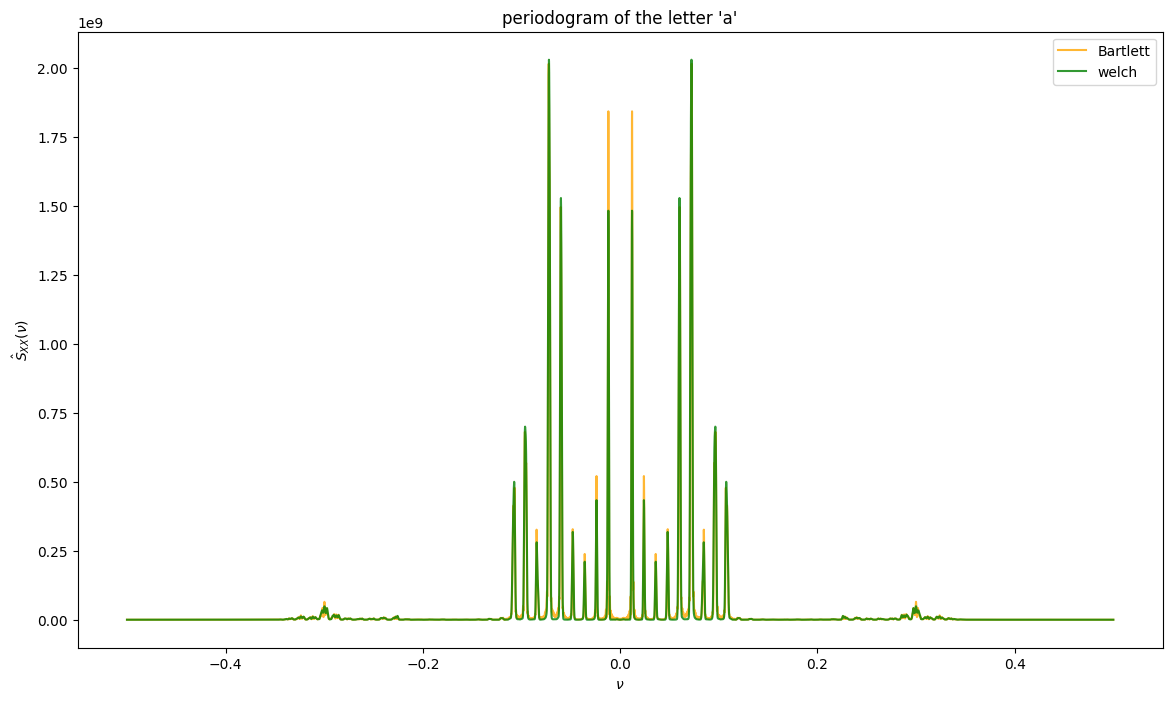

In [25]:
fig = plt.figure(figsize=(14, 8))

# bartlett
nus, S_hat_bartlett = periodogram(letter_a, method="Bartlett", M = 1000)
plt.plot(nus, S_hat_bartlett, c='orange', alpha=.8, label="Bartlett")

# welch
nus, S_hat_welch = periodogram(letter_a, method="Welch", M = 1000)
plt.plot(nus, S_hat_welch, c='green', alpha=.8, label="welch")

plt.title("periodogram of the letter 'a'")
plt.xlabel(r"$\nu$")
plt.ylabel(r"$\hat{S}_{XX}(\nu)$")
plt.legend()
plt.show()

What a result ! We can see the harmonics of the letter a ! 

# 2 - Sum of noisy signals 

## 2.1 Synthesis 

In [26]:
def gen_noisy_sinusoids(N,amp, freqs, ophases, noisevariance):
    signal = np.zeros(N)
    K = len(amp)
    for i in range(N): 
        for j in range(K): 
            signal[i] += amp[j]*np.sin(2*np.pi*freqs[j]*i + phases[j])
    signal += np.random.normal(0, np.sqrt(noisevariance), N)
    return signal                         

In [51]:
N = 4000
freqs  = np.array([.15, .30])
amp   = np.array([1, 1])
phases = np.array([0, 0])
sigma2 = 5
noisy_signal = gen_noisy_sinusoids(N, amp, freqs, phases, sigma2)

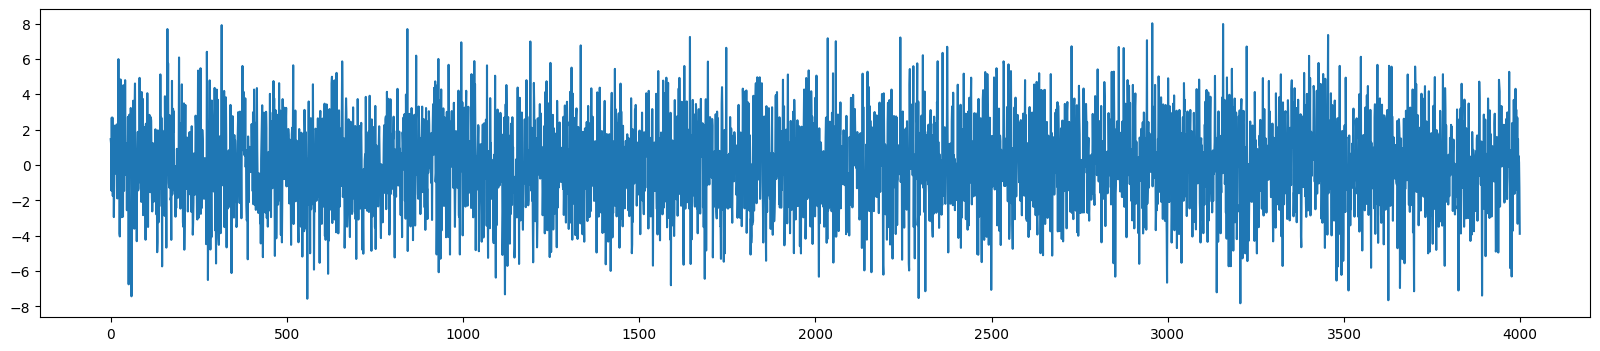

In [52]:
fig = plt.figure(figsize=(20, 4))
plt.plot(noisy_signal)
plt.show()

In [29]:
def resolution(noisy_sig, freqs, noise_variance):

    fig = plt.figure(figsize=(40, 12))

    # std    
    nus, S_hat_std = periodogram(noisy_sig, method="std")
    plt.plot(nus, S_hat_std, c='orange', alpha=.5, label="std")
    
    # bartlett    
    nus, S_hat_bartlett = periodogram(noisy_sig, method="Bartlett", M = 35)
    plt.plot(nus, S_hat_bartlett, c='red', label="Bartlett")
    
    # welch    
    nus, S_hat_welch = periodogram(noisy_sig, method="Welch", M = 35 )
    plt.plot(nus, S_hat_welch, c='blue', label="Welch")
    
    # draw vertical lines
    for freq in freqs:
        plt.axvline(x=freq, color='black', linestyle='--', alpha=1, label="pure sine")
    # draw a horizontal line
    plt.axhline(y=noise_variance, color='black', linestyle=':', label="noise")
    
    plt.title("periodogram of a signal with sines and noise")
    plt.xlabel(r"$\nu$")
    plt.ylabel(r"$\hat{S}_{XX}(\nu)$")
    plt.ylim(noise_variance/5, noise_variance*50) # zoom on the interesting part
    plt.yscale("log")
    plt.legend()

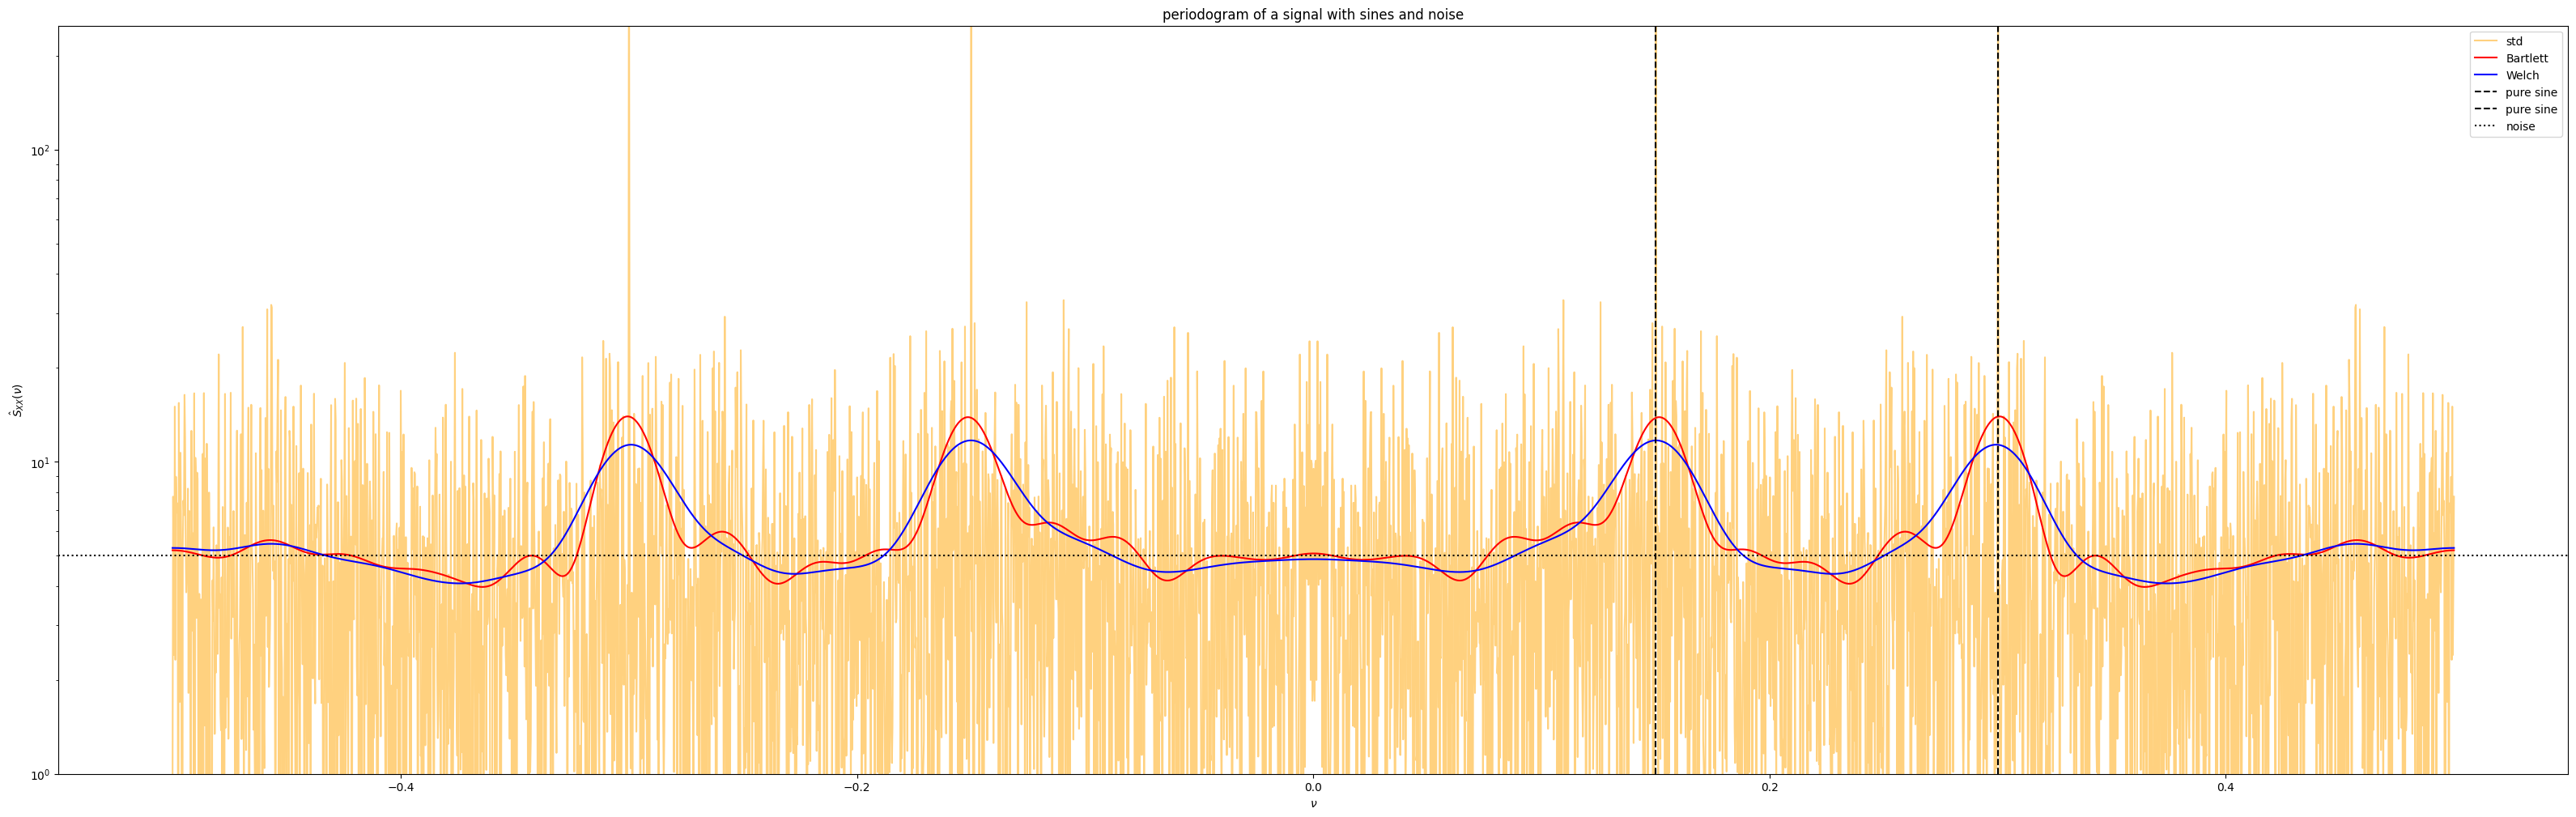

In [30]:
sigma2 = 5
resolution(noisy_signal,freqs,sigma2)

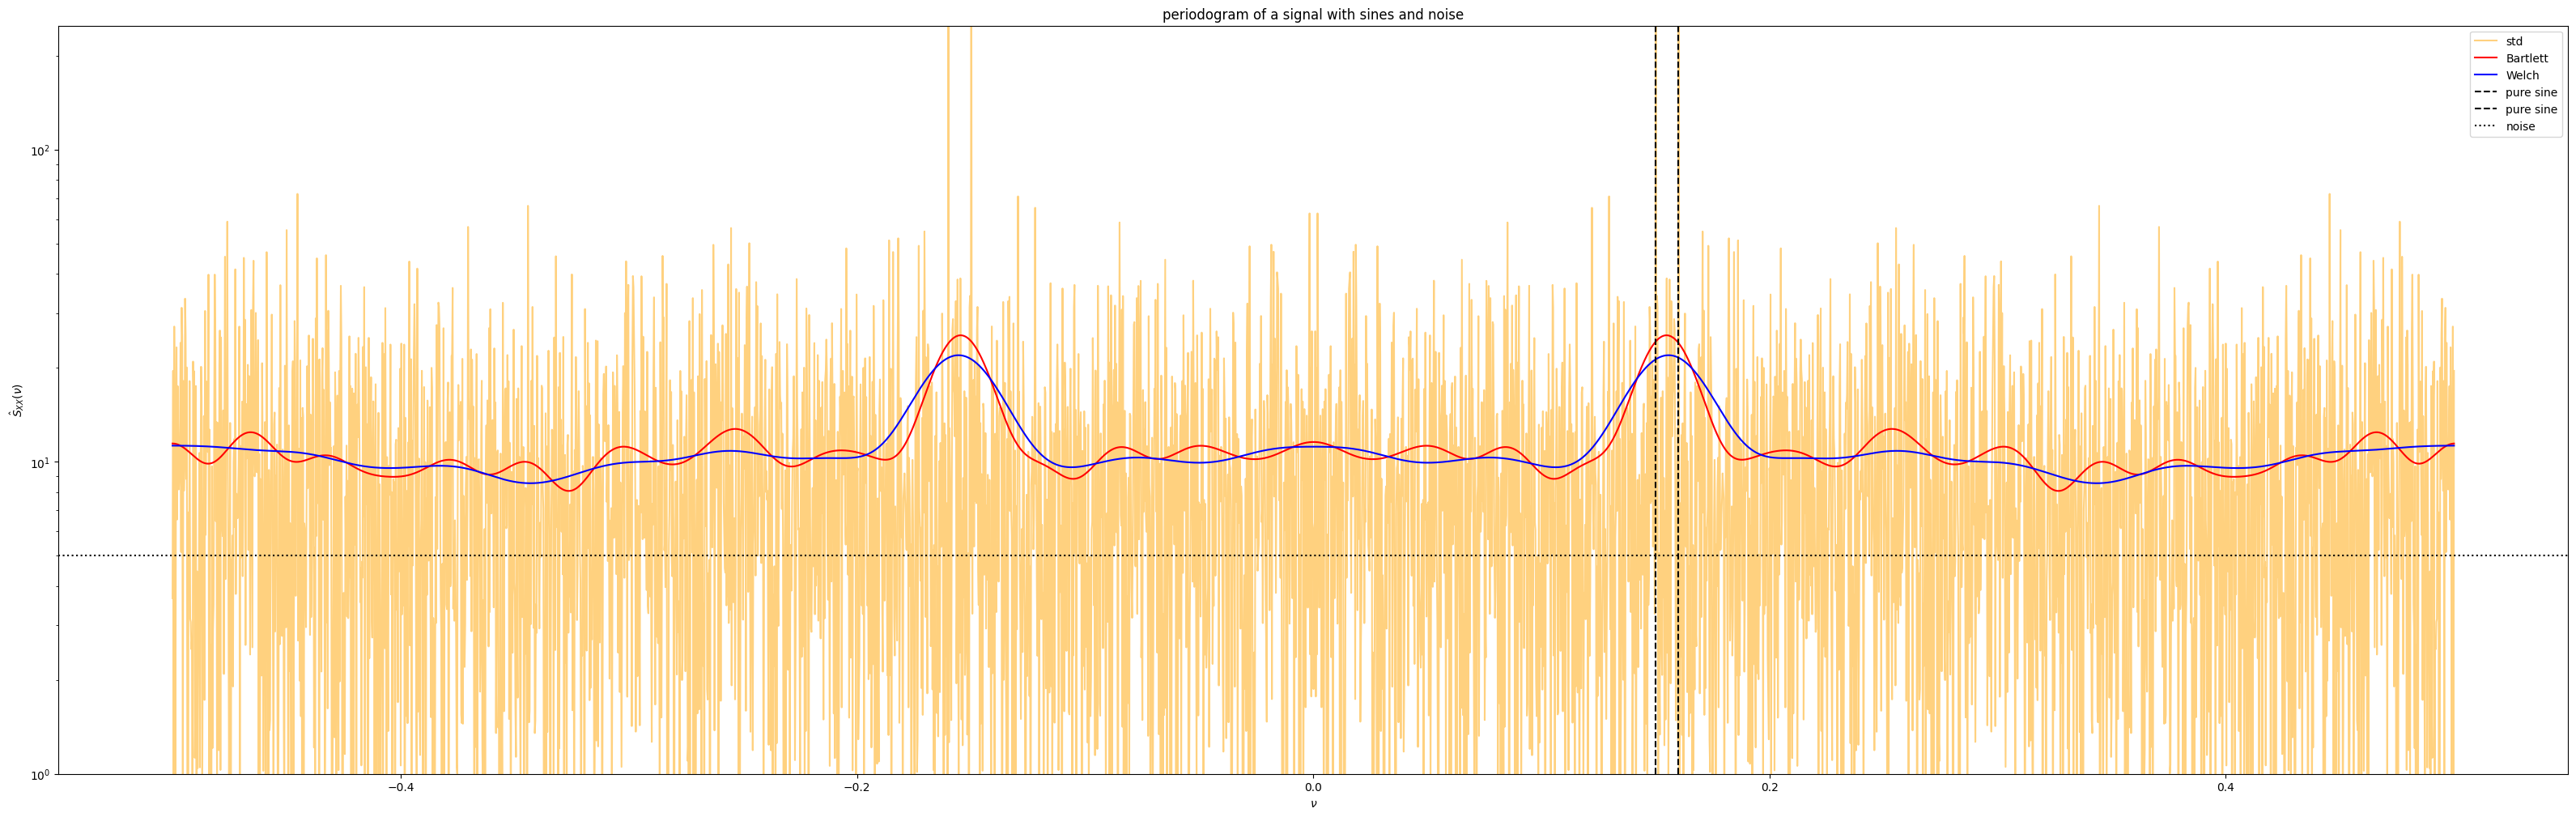

In [31]:
#High noise, and two very close frequencies
signal = gen_noisy_sinusoids(N,amp,np.array([0.15,0.16]),phases,10)
resolution(signal,np.array([0.15,0.16]),sigma2)

#Detects only one frequence 

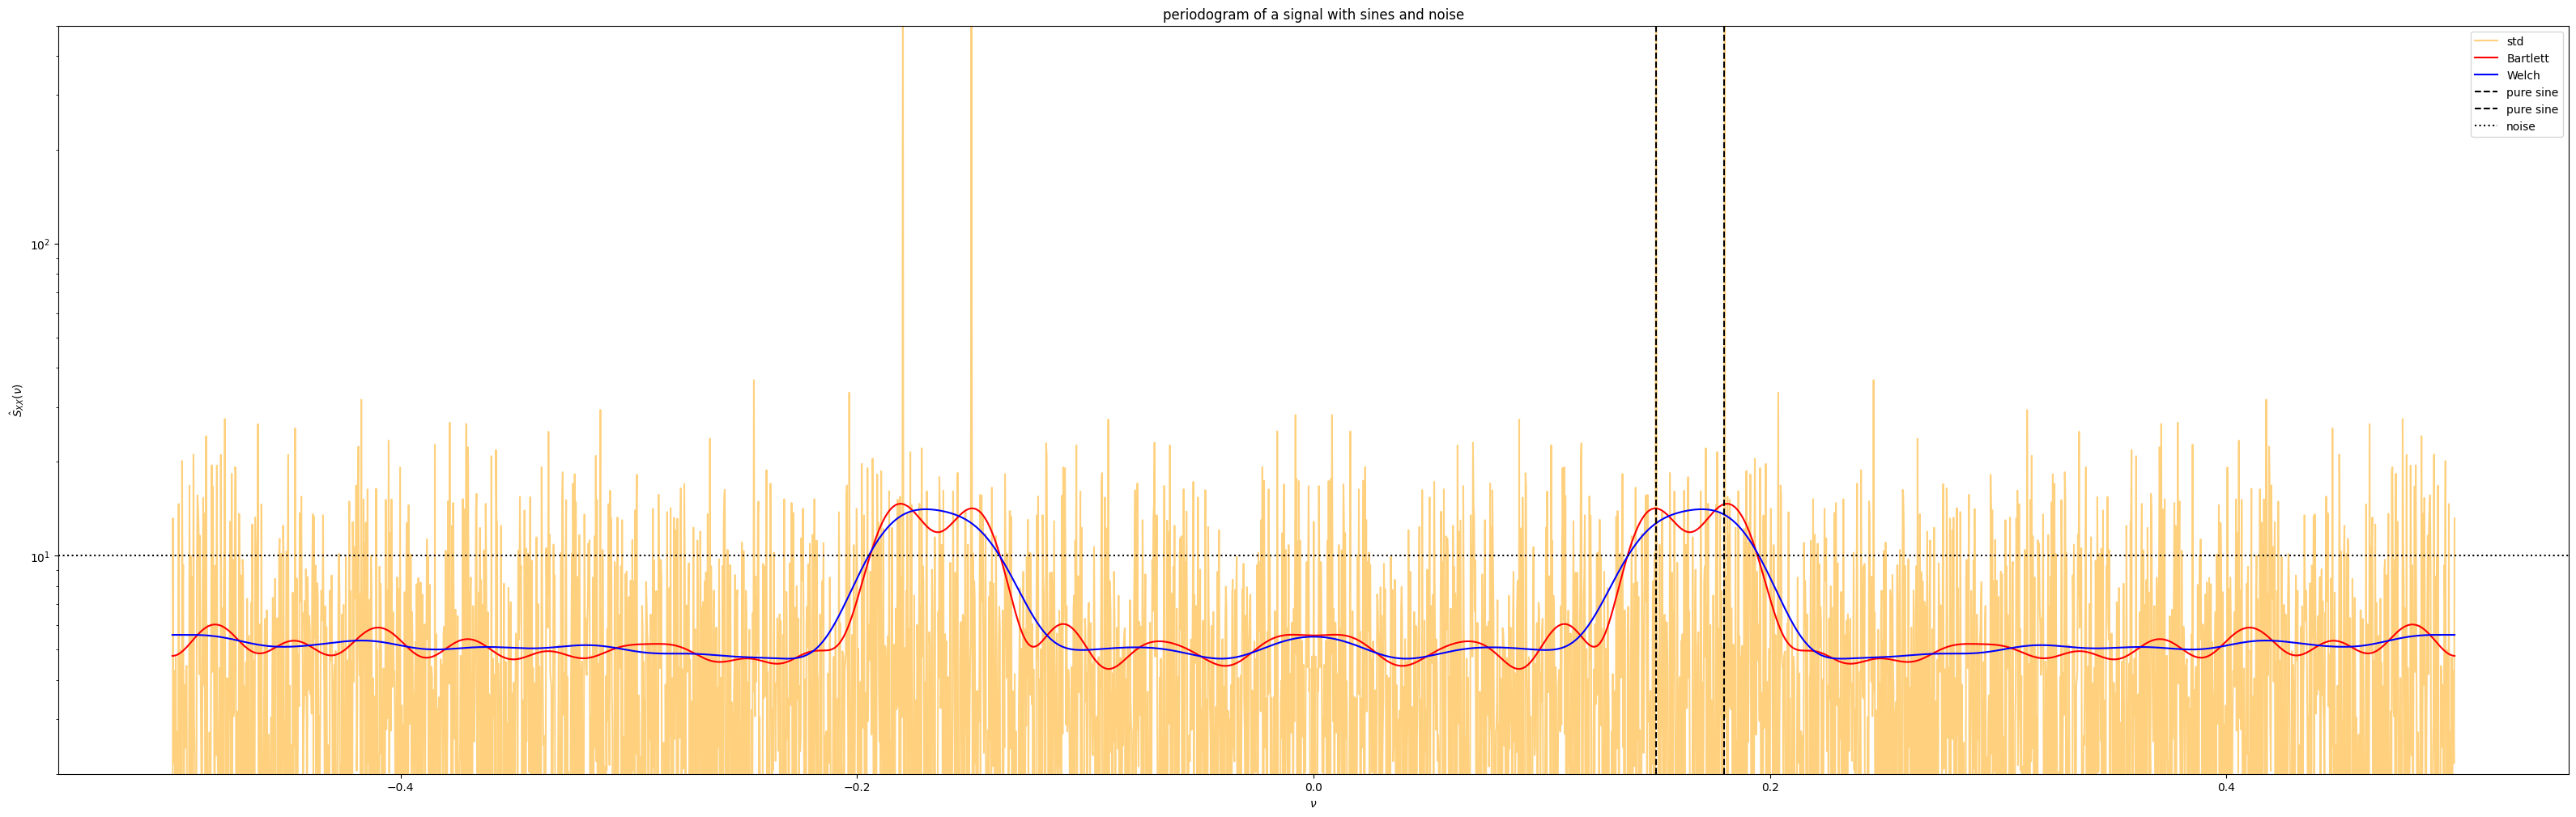

In [32]:
#High noise, and two very close frequencies
resolution(gen_noisy_sinusoids(N,amp,np.array([0.15,0.18]),phases,5),np.array([0.15,0.18]),10)

# Bartlett sees two frequencies whereas Welch sees only one ! 

The standard periodogram seems to be the best to predict the different frequencies. 
Bartlett seems to be the second method with most resolution. 
Welch method has the worst resolution. 

We can see that there is a compromise that has to be made between __variance__ of the perodiogram and __frequency resolution__. 

### 2.3 - Parametric estimation : linear prediction

In [33]:
print(srlm.burg(noisy_signal , order=4))

(array([ 0.03376268, -0.0944111 , -0.03467167, -0.04395623]), 5.872047439683675)


In [34]:
def ARestimation(signal, freqs, variance, order):
    estimated_coeffs_burg, estimated_sigma2_burg = srlm.burg(signal, order)
    #estimation of the psd of the AR
    nus = np.linspace(-.5, .5, num=N)
    estimated_coeffs = np.concatenate(([1], -estimated_coeffs_burg))
    a_Sxx_burg = estimated_sigma2_burg / (np.abs(np.fft.fft(estimated_coeffs, n=N)))**2
    a_Sxx_burg = np.roll(a_Sxx_burg, a_Sxx_burg.size//2)
    plt.plot(nus, a_Sxx_burg, c='orange', label="Yule-Walker linear prediction")
    
    # draw vertical lines
    for freq in freqs:
        plt.axvline(x=freq, color='black', linestyle='--', label="sine")
        #plt.axvline(x=-freq, color='black', linestyle='--', label="sine")
    # draw a horizontal line
    plt.axhline(y=variance, color='black', linestyle='--', label="noise")
    plt.title(f"periodogram of an AR-({order}) estimate of noisy sines")
    plt.xlabel(r"$\nu$")
    plt.ylabel(r"$\hat{S}_{XX}(\nu)$")
    #plt.yscale("log")
    plt.legend()
    plt.show()

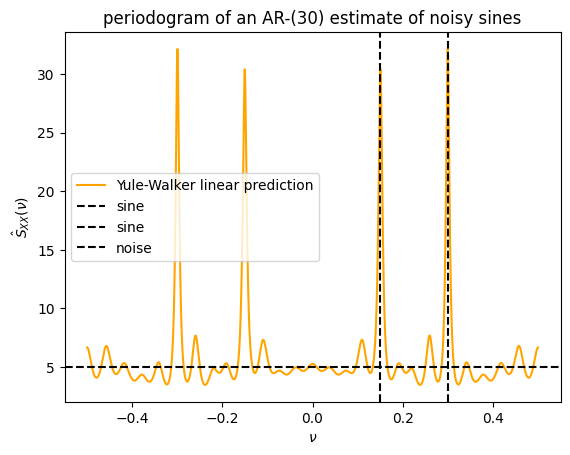

In [35]:
variance = 5 
frequence = np.array([0.15,0.30])
ARestimation(noisy_signal,frequence,variance,order = 30)

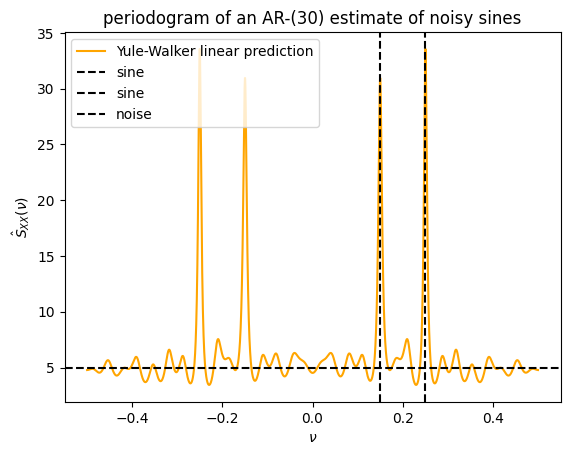

In [36]:
variance = 5 
frequence = np.array([0.15,0.25])
ARestimation(gen_noisy_sinusoids(N, amp, frequence, phases, sigma2),frequence,variance,order = 30)

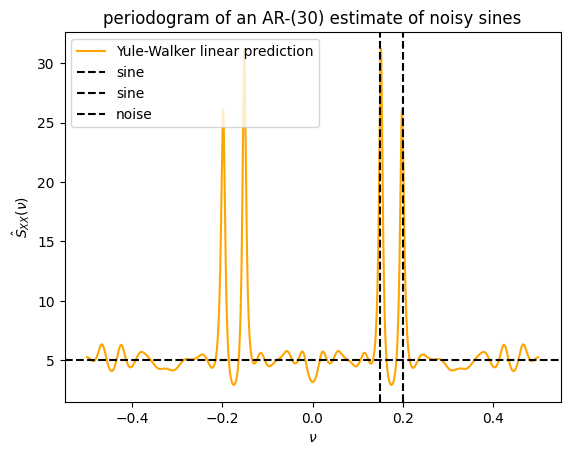

In [37]:
variance = 5 
frequence = np.array([0.15,0.2])
ARestimation(gen_noisy_sinusoids(N, amp, frequence, phases, sigma2),frequence,variance,order = 30)

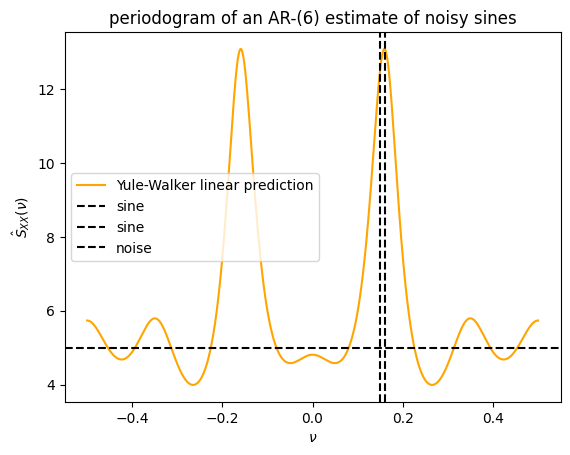

In [38]:
variance = 5 
frequence = np.array([0.15,0.16])
ARestimation(gen_noisy_sinusoids(N, amp, frequence, phases, sigma2),frequence,variance,order =6)

### 2.4 Parametric estimation : Capon estimator 

In [ ]:
def Capon(signal, nu, inverseR):
    N = signal.size
    e = np.matrix([np.exp(2*1j*np.pi*nu*n) for n in range(N)])
    tmp = N / (e @ inverseR @ e.H)
    return np.abs(tmp.A[0][0])

In [56]:
def compute_invR(sig):
    """compute the inverse of the empirical autocovariance matrix of sig
    sig is assumed to be real-valued"""
    N = sig.size
    R = np.zeros((N, N))
    # don't use, so very long...
    # col = np.array([np.sum([foo[t+k-1]*foo[t-1] for t in range(1, N-k+1)]) for k in range(N)]) / N
    col = np.convolve(sig, np.flip(sig))[-N:] / N # \hat{r}_{XX}(k) for k in {0, ..., N-1}
    for n in range(N):
        R[n:, n] = col[:N-n]
    R += np.triu(R.T, 1)
    return np.linalg.inv(R)

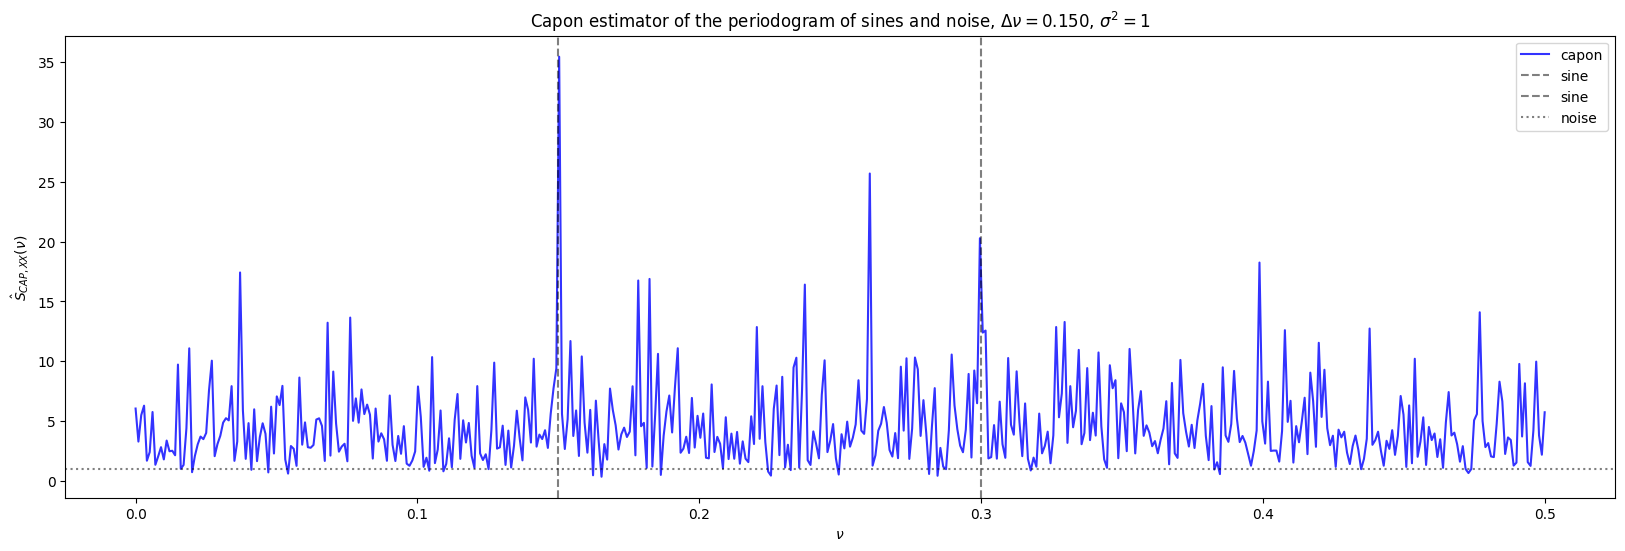

In [71]:
def capon_plot(noisy_sig, freqs, noise_variance):
    
    nus = np.linspace(0, .5, num=500)
    fig = plt.figure(figsize=(20, 6))
    
    invR = compute_invR(noisy_sig)
    S_hat_capon = [capon(noisy_sig, nu, invR) for nu in nus]
    
    plt.plot(nus, S_hat_capon, c='blue', alpha=.8, label="capon")
    
    # draw vertical lines
    for freq in freqs:
        plt.axvline(x=freq, color='black', linestyle='--', alpha=0.5, label="sine")
        #plt.axvline(x=-freq, color='black', linestyle='--', label="sine")
    # draw a horizontal line
    plt.axhline(y=noise_variance, color='black', linestyle=':', alpha=0.5, label="noise")
    
    plt.legend()
    plt.title(rf"Capon estimator of the periodogram of sines and noise, "
              rf"$\Delta \nu =${np.abs(freqs[0]-freqs[1]):.3f}, $\sigma^2 =${noise_variance}")
    plt.xlabel(r"$\nu$")
    plt.ylabel(r"$\hat{S}_{CAP, XX}(\nu)$")

capon_plot(noisy_signal, np.array([0.15,0.30]), 1)

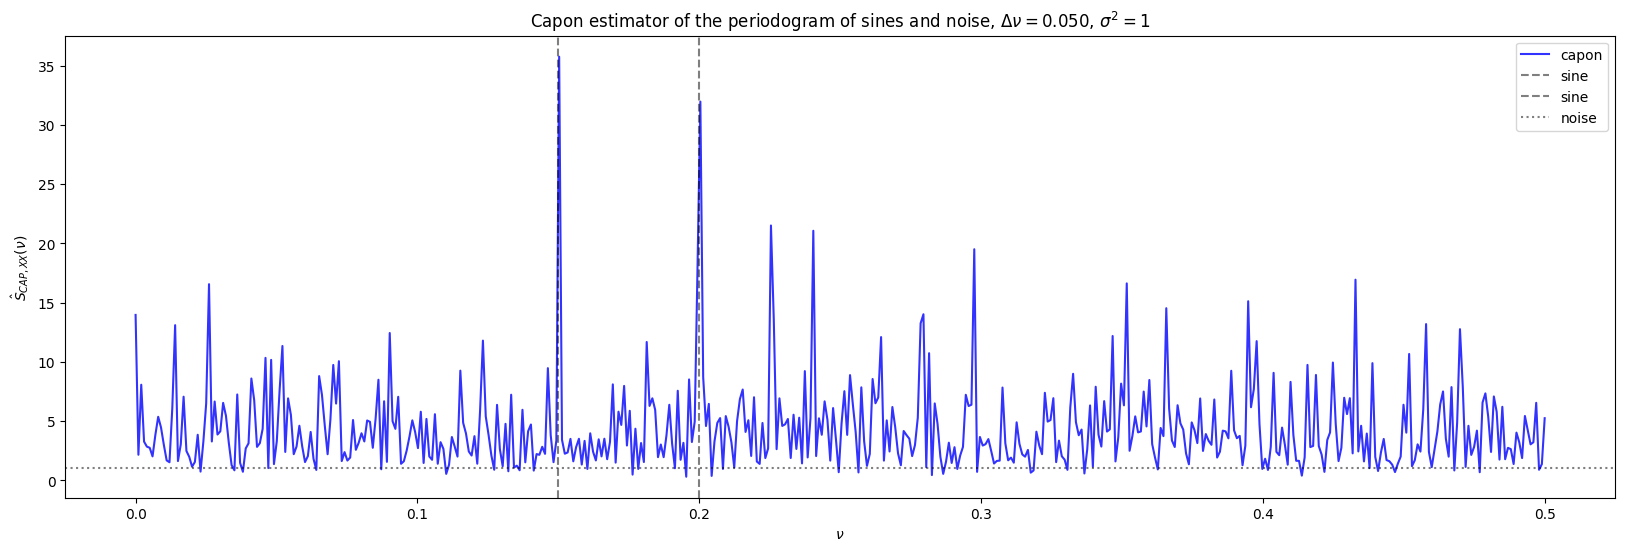

In [72]:
capon_plot(gen_noisy_sinusoids(N, amp,np.array([0.15,0.20]), phases, sigma2), np.array([0.15,0.20]), 1)

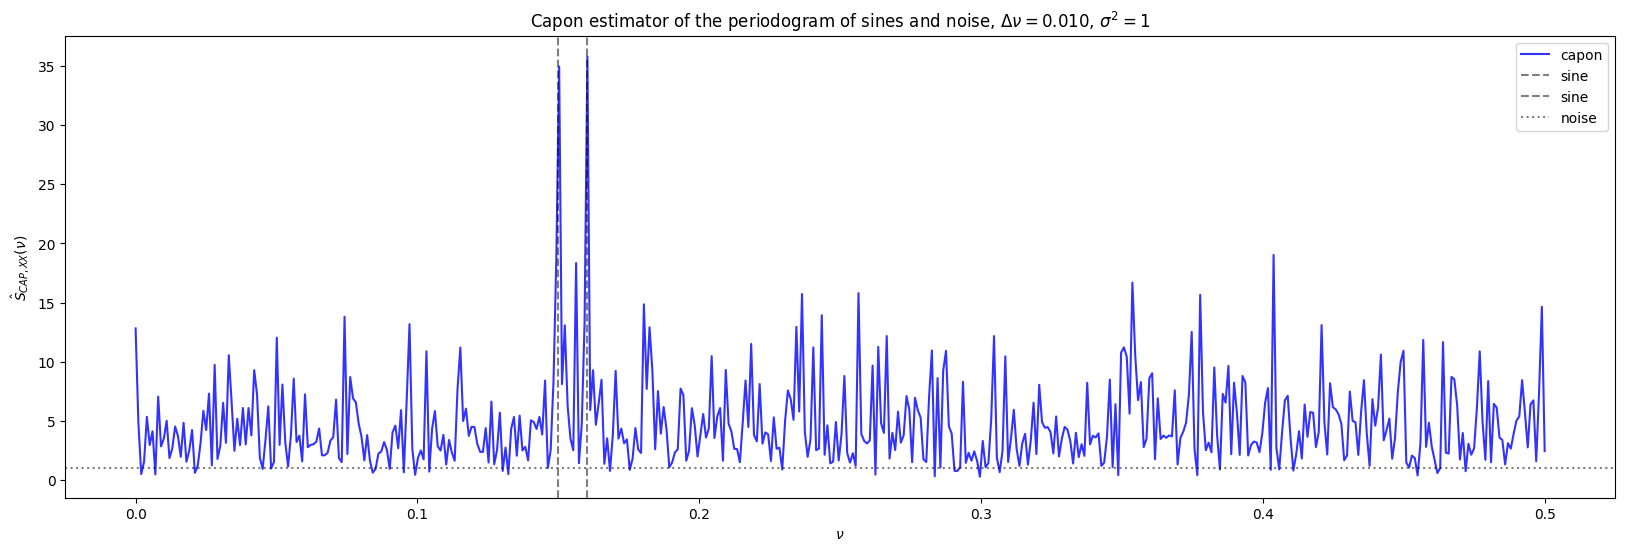

In [74]:
capon_plot(gen_noisy_sinusoids(N, amp,np.array([0.15,0.16]), phases, sigma2), np.array([0.15,0.16]), 1)

### 3 - Autoregressive moving average
#### 3.1 Synthesis

A process is ARMA(p,q) if and only if it is Wide Sens Stationary and it verifies :
$$ \forall t , X_t = Z_t +  \sum_{m=1}^p a_m Z_{t-m} + \sum_{n=1}^q a_n X_{t-n}$$ 

With $Z ~ WN(0, \sigma^2)$ and  $A(z)$ and $B(z)$ having no common roots.


In [75]:
def ARMA(N, acoeffs, bcoeffs, sigma2):
    """Returns a numpy array of length N with samples
    from an ARMA process with coefficients
    acoeffs = [a_1, a_2, ...]
    bcoeffs = [b_1, b_2, ...]
    and noise variance sigma2"""
    proc = np.zeros(N)
    p = acoeffs.size
    q = bcoeffs.size
    sigma = np.sqrt(sigma2)
    Z = np.random.normal(0, sigma, N)
    for t in range(N):
        proc[t] = (Z[t] + np.sum([bcoeffs[n-1] * Z[t-n]    for n in range(1, q+1)])
                        + np.sum([acoeffs[m-1] * proc[t-m] for m in range(1, p+1)]))
    return proc

#### 3.2 Non-parametric estimation : periodogram

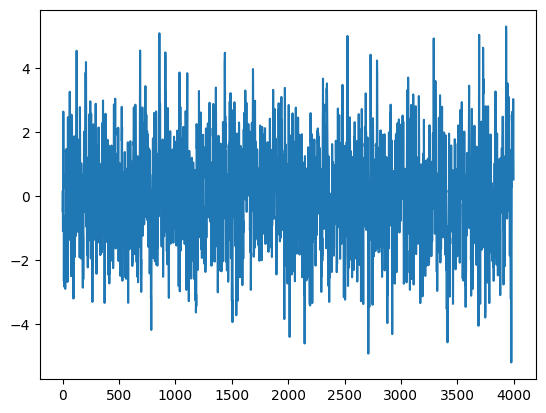

In [76]:
N = 4000
acoeffs = np.array([0.6])
bcoeffs = np.array([0.2])
sigma2 = 1
ARMA_0 = ARMA(N, acoeffs, bcoeffs, sigma2)
plt.plot(ARMA_0)
plt.show()

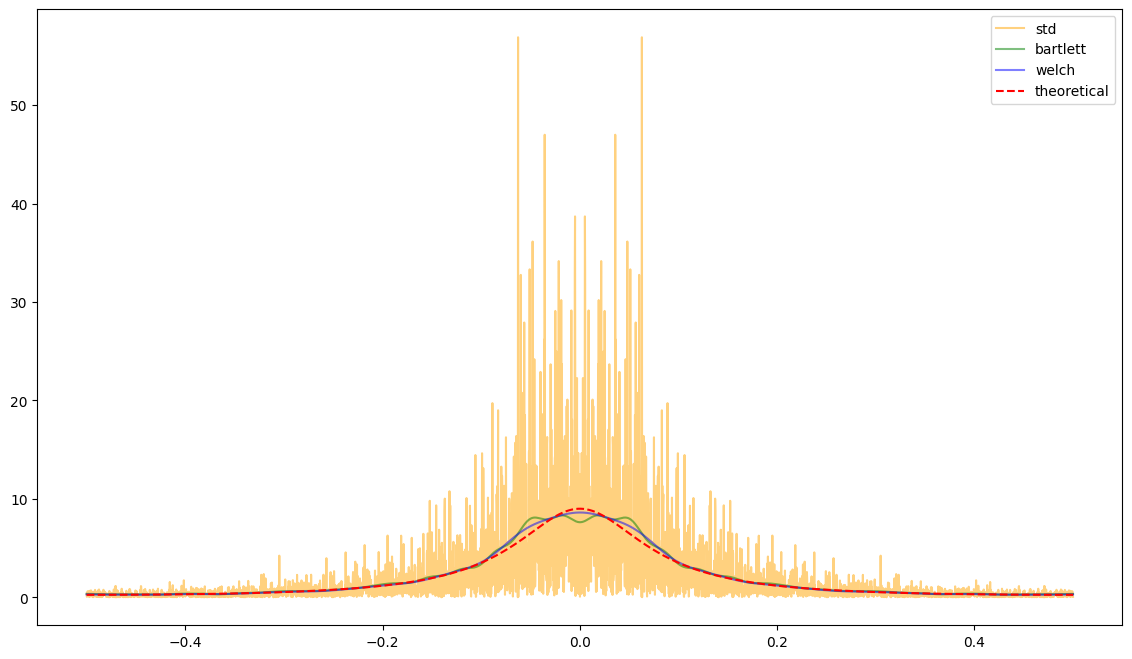

In [77]:
fig = plt.figure(figsize=(14,8))

# std
nus, S_hat_std = periodogram(ARMA_0, method="std")
np.roll(S_hat_std, S_hat_std.size//2)
plt.plot(nus, S_hat_std, c='orange', alpha=.5, label="std")

# barlett
nus_bartlett, S_hat_bartlett = periodogram(ARMA_0, method="Bartlett", M= 35)
plt.plot(nus_bartlett, S_hat_bartlett, c='green', alpha=.5, label="bartlett")

# welsh 
a, b = periodogram(ARMA_0,method='Welch', M= 35)
plt.plot(a, b, c='blue', alpha=.5, label="welch")

Sxx = [sigma2 * np.abs(1 + bcoeffs[0]*np.exp(-2*1j*np.pi*nu))**2 / np.abs(1 - acoeffs[0]*np.exp(-2*1j*np.pi*nu))**2 for nu in nus]
plt.plot(nus, Sxx, c='r', linestyle='dashed', label="theoretical")


plt.legend()

In [78]:
#std
biais_std = np.mean(S_hat_std) - np.mean(Sxx)
variance_std = np.var(S_hat_std)
print(f"### method std:\nbias= {biais_std}\nvariance= {variance_std}")

# bartlett
biais_barlett = np.mean(S_hat_bartlett) - np.mean(Sxx)
variance_barlett = np.var(S_hat_bartlett)
print(f"### method bartlett:\nbias= {biais_barlett}\nvariance= {variance_barlett}")

# welch
biais_welch = np.mean(S_hat_welch) - np.mean(Sxx)
variance_welch = np.var(S_hat_welch)
print(f"### method welch:\nbias= {biais_welch}\nvariance= {variance_welch}")

### method std:
bias= 0.09502068020300536
variance= 18.868070600756713
### method bartlett:
bias= 0.08664232717808629
variance= 6.469473004238234
### method welch:
bias= 32037051.025998123
variance= 2.8493009245824716e+16


In [79]:
from numpy import pi

def durbin(sig, p, q):
    """computes the estimated parameters of an
    ARMA-(p,q) process sig using the Durbin method
    sig is assumed to be real-valued"""
    
    N = sig.size
    
    ### estimation of the AR part (modified Yule-Walker Method)
    R = np.zeros((p, p))

   
    r = np.convolve(sig, np.flip(sig))[N+q-1:N+q+p] / N 
    for n in range(p):
        R[n:, n] = r[:p-n]
    R += np.triu(R.T, 1) # fill the upper part by symmetry
    # solve the modified Yule-Walker equations
    invR = np.linalg.inv(R)
    ahat = invR @ r[1:]
    # compute sigma2_hat
    r = np.convolve(sig, np.flip(sig))[N-1:N+p] / N 
    sigma2_hat = np.abs(r[0] - np.sum(ahat*r[1:]))
    
    ### estimation of the MA part (Durbin method)
    ahatexp = np.concatenate(([1], -ahat))
    Y = np.convolve(sig, ahatexp)
    NY = Y.size
    L = 64*q # >> q
    RY = np.zeros((L, L))
    rY = np.convolve(Y, np.flip(Y))[NY-1:NY+L] / N
    for n in range(L):
        RY[n:, n] = rY[:L-n]
    RY += np.triu(RY.T, 1) 
    # solve the modified Yule-Walker equations
    invRY = np.linalg.inv(RY)
    ahatY = invRY @ rY[1:]
    
    ### compute the sequence \hat{r}_L
    r_hat_L = np.zeros(2*L+1)
    pow2 = 2**13 
    ahatexp = np.concatenate(([1], -ahatY))
    n = max(pow2, int(2**np.ceil(np.log2(ahatexp.size))))
    ft = np.abs(np.fft.fft(ahatexp, n=n))**2
    for k in range(-L, L+1):
        integrand = ft * np.cos(2*pi*k*np.arange(pow2)/pow2) # for the inverse Fourier transform
        r_hat_L[k] = np.sum(integrand) / pow2 # simple quadrature method integration
    
    ### estimate an AR-(q) on r_hat_L
    Nr = r_hat_L.size
    Rr = np.zeros((q, q))
    rr = np.convolve(r_hat_L, np.flip(r_hat_L))[Nr-1:Nr+q] / N 
    for n in range(q):
        Rr[n:, n] = rr[:q-n]
    Rr += np.triu(Rr.T, 1) 
    # solve the modified Yule-Walker equations
    invRr = np.linalg.inv(Rr)
    bhat = invRr @ rr[1:]
    
    return (ahat, -bhat, sigma2_hat) 

#### 3.3 Parametric estimation : Durbin method

In [81]:
AR_coeffs_estimated, MA_coeffs_estimated, sigma_value = durbin(ARMA_0, 1, 1)
print("AR coeffs estimated: ", AR_coeffs_estimated)
print("MA coeffs estimated: ", MA_coeffs_estimated)
print("sigma estimated: ", sigma_value)

AR coeffs estimated:  [0.62180379]
MA coeffs estimated:  [0.19257574]
sigma estimated:  1.1620453857122683


The values are consistent

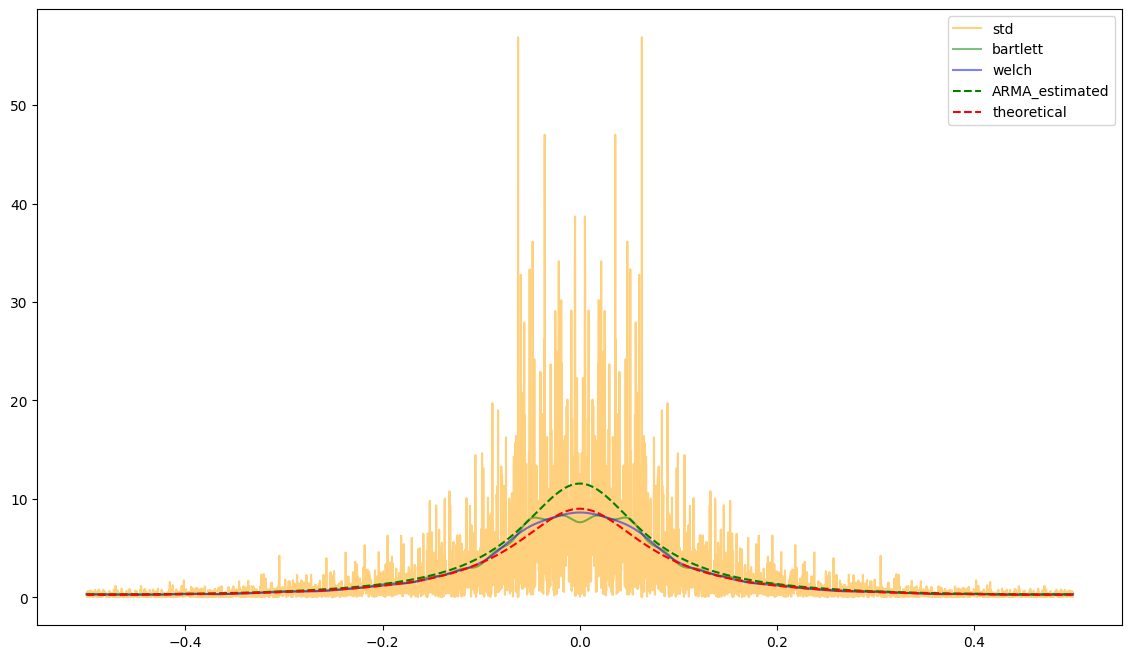

In [82]:
fig = plt.figure(figsize=(14,8))

# std
nus, S_hat_std = periodogram(ARMA_0, method="std")
np.roll(S_hat_std, S_hat_std.size//2)
plt.plot(nus, S_hat_std, c='orange', alpha=.5, label="std")

# barlett
nus_bartlett, S_hat_bartlett = periodogram(ARMA_0, method="Bartlett", M= 35)
plt.plot(nus_bartlett, S_hat_bartlett, c='green', alpha=.5, label="bartlett")

# welsh 
a, b = periodogram(ARMA_0,method='Welch', M= 35)
plt.plot(a, b, c='blue', alpha=.5, label="welch")

S_hat_ARMA = [sigma_value * np.abs(1 + MA_coeffs_estimated[0]*np.exp(-2*1j*np.pi*nu))**2 / np.abs(1 - AR_coeffs_estimated[0]*np.exp(-2*1j*np.pi*nu))**2 for nu in nus]
plt.plot(nus, S_hat_ARMA, c='green', linestyle='dashed', label="ARMA_estimated")

Sxx = [sigma2 * np.abs(1 + bcoeffs[0]*np.exp(-2*1j*np.pi*nu))**2 / np.abs(1 - acoeffs[0]*np.exp(-2*1j*np.pi*nu))**2 for nu in nus]
plt.plot(nus, Sxx, c='r', linestyle='dashed', label="theoretical")


plt.legend()

In [83]:
data_path = os.getcwd()
filename = 'an_in_on.wav'
sound = os.path.join(data_path, filename)

In [ ]:
play_sound(sound)

In [84]:
wavefile = load_sound(sound)
Fs = int(wavefile.getframerate())
num_samples = int(wavefile.getnframes())
data = wavefile.readframes(num_samples)
data = struct.unpack('{n}h'.format(n=num_samples), data)
x = np.array(data)
print(Fs)

16000


In [85]:
timestep = 1/float(Fs)
times = np.arange(len(x))*timestep

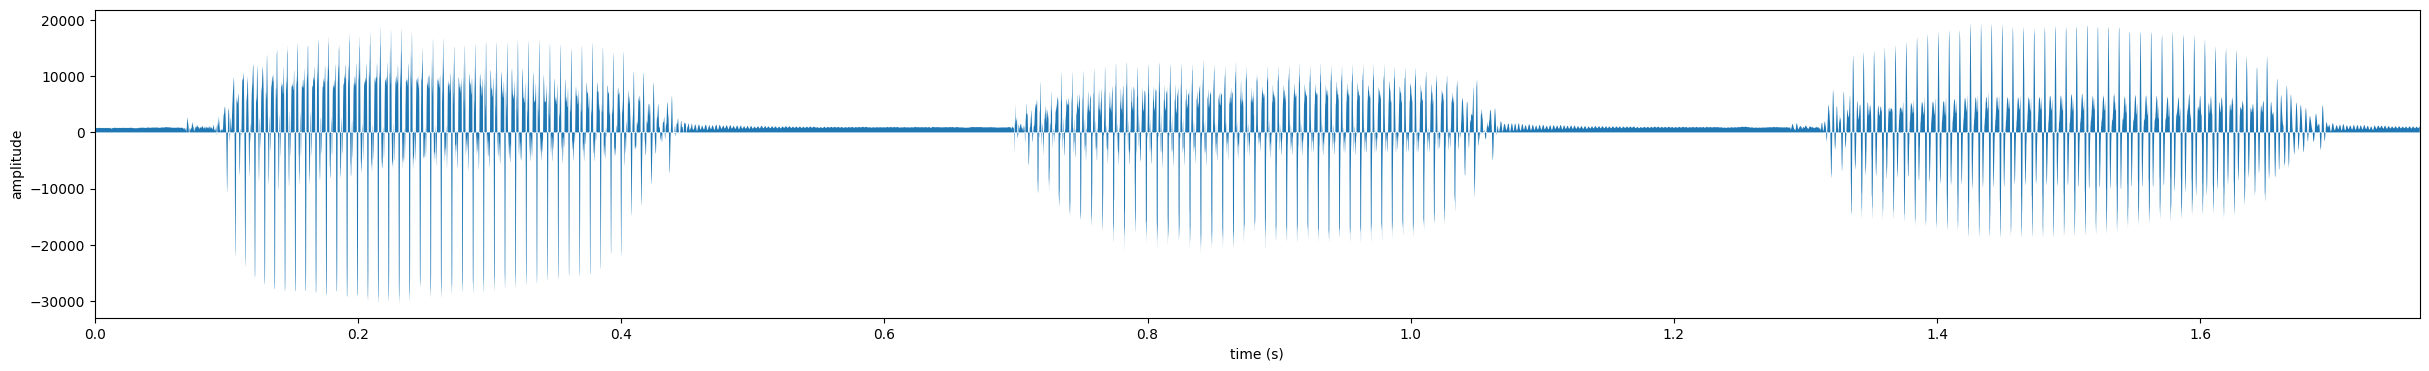

In [86]:
plot_sound(x, times)

In [87]:
AR_coeffs_estimated, MA_coeffs_estimated, sigma_value = durbin(x, 1, 1)
print("AR coeffs estimated: ", AR_coeffs_estimated)
print("MA coeffs estimated: ", MA_coeffs_estimated)
print("sigma estimated: ", sigma_value)

AR coeffs estimated:  [0.96138325]
MA coeffs estimated:  [0.91090453]
sigma estimated:  2128576.472904131


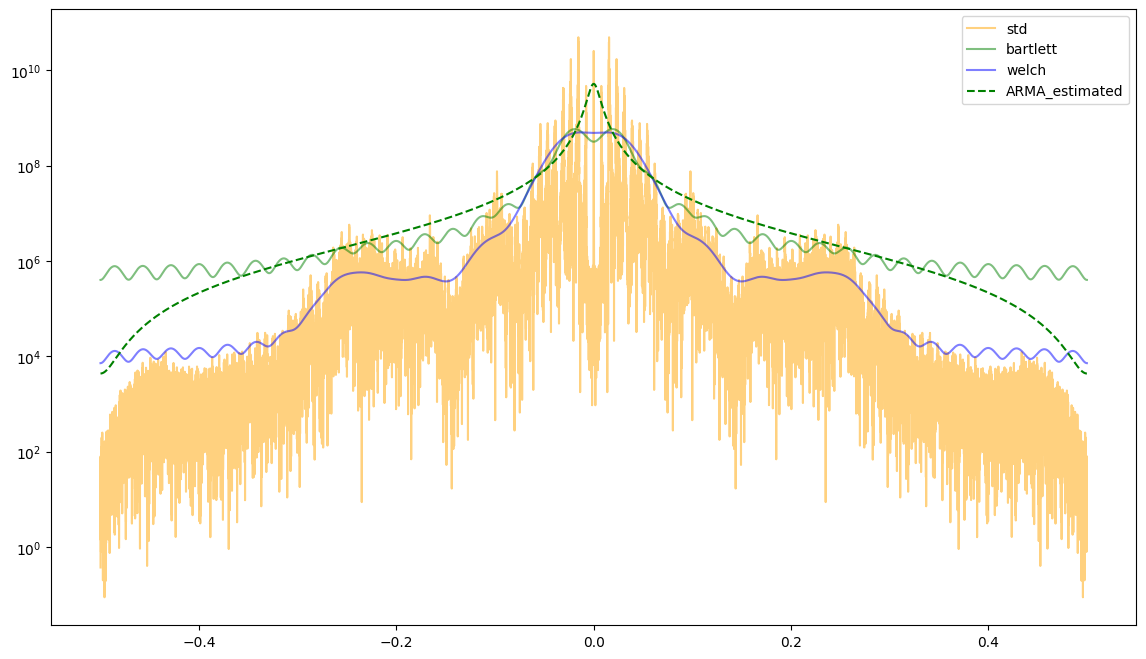

In [88]:
fig = plt.figure(figsize=(14,8))

# std
nus, S_hat_std = periodogram(x, method="std")
np.roll(S_hat_std, S_hat_std.size//2)
plt.plot(nus, S_hat_std, c='orange', alpha=.5, label="std")

# barlett
nus_bartlett, S_hat_bartlett = periodogram(x, method="Bartlett", M= 35)
plt.plot(nus_bartlett, S_hat_bartlett, c='green', alpha=.5, label="bartlett")

# welsh 
a, b = periodogram(x,method='Welch', M= 35)
plt.plot(a, b, c='blue', alpha=.5, label="welch")

S_hat_ARMA = [sigma_value * np.abs(1 + MA_coeffs_estimated[0]*np.exp(-2*1j*np.pi*nu))**2 / np.abs(1 - AR_coeffs_estimated[0]*np.exp(-2*1j*np.pi*nu))**2 for nu in nus]
plt.plot(nus, S_hat_ARMA, c='green', linestyle='dashed', label="ARMA_estimated")


plt.legend()
plt.yscale("log")
plt.show()